# Regression solution using Pycaret

## 1.0 - Libraries & Functions

In [96]:
# data extraction & manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and modeling
from pycaret.regression import (
    setup, create_model, compare_models, plot_model,
    get_config, evaluate_model, predict_model, finalize_model,
    save_model, tune_model
)
from pycaret.utils import check_metric

## 2.0 - Data extraction

In [73]:
df = pd.read_csv('datasets/volkswagen.csv')

In [74]:
# spliting data train and test validation
df_train = df.sample(frac=0.95, random_state=786)
df_test = df.drop(df_train.index, axis=0)

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

In [4]:
df_train.shape, df_test.shape

((14399, 9), (758, 9))

## 3.0 - Data Analysis

In [93]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [6]:
print(f'rows and columns: {df_train.shape}')
cols = df_train.columns
top = [df_train[col].value_counts().reset_index().loc[0, 'index'] for col in cols]
desc = pd.concat([
    df_train.dtypes,
    df_train.isna().mean() * 100,
    df_train.nunique(),
    df_train.mean(),
    df_train.std(),
    df_train.min(),
    df_train.max(),
    df_train.sample(4).T
    ], axis=1
).round(2)
cols = ['dtypes', '%_null', 'unique', 'mean', 'std',
    'min', 'max', 0, 1, 2,3]
desc.columns = cols
desc

rows and columns: (14399, 10)


,dtypes,%_null,unique,mean,std,min,max,0,1,2,3
index,int64,0.0,14399,7581.31,4371.47,0,15155,367,8267,14359,2992
model,object,0.0,27,NaN,NaN,Amarok,Up,T-Roc,Polo,Touran,Golf
year,int64,0.0,21,2017.25,2.06,2000,2020,2018,2017,2011,2013
price,int64,0.0,3856,16809.87,7736.91,899,69994,19595,9490,7995,6991
transmission,object,0.0,3,NaN,NaN,Automatic,Semi-Auto,Manual,Manual,Semi-Auto,Manual
mileage,int64,0.0,10307,22109.31,21155.37,1,212000,8554,22952,63700,69711
fuelType,object,0.0,4,NaN,NaN,Diesel,Petrol,Diesel,Petrol,Diesel,Diesel
tax,int64,0.0,32,112.63,63.47,0,580,145,20,165,0
mpg,float64,0.0,86,53.77,13.63,0.3,188.3,50.4,60.1,49.6,74.3
engineSize,float64,0.0,12,1.60,0.46,0.0,3.2,1.6,1.0,2.0,1.6


In [57]:
df_train['year'].value_counts()

2019    4428
2017    2812
2016    2499
2018    1427
2015    1105
2020     995
2014     558
2013     294
2012      79
2011      55
2010      40
2009      30
2008      25
2007      19
2006      14
2005       8
2001       4
2004       3
2003       2
2000       1
2002       1
Name: year, dtype: int64

Text(0.5, 1.0, 'Normalized price box plot')

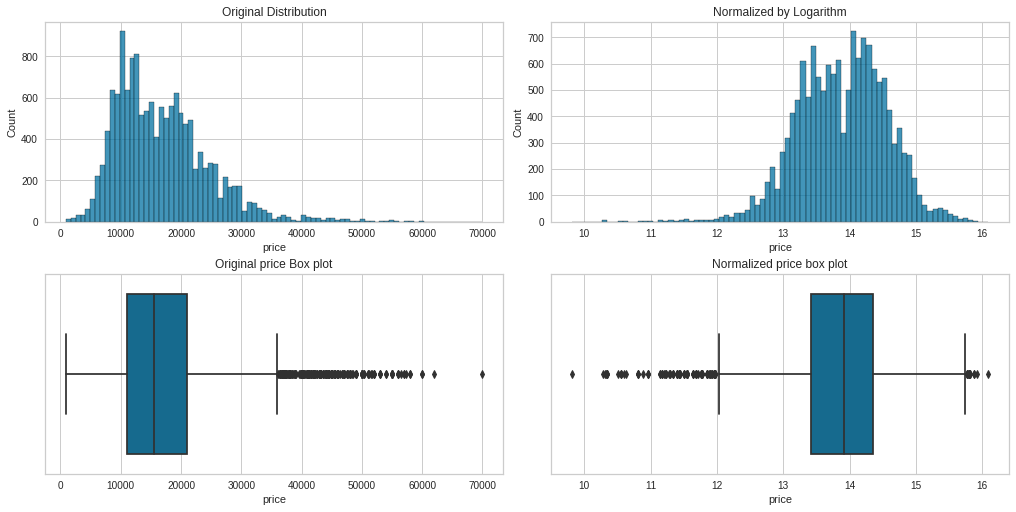

In [49]:
fig = plt.figure(constrained_layout=True, figsize=(14,7))
spec = plt.GridSpec(ncols=2, nrows=2, figure=fig)
# original
ax1 = fig.add_subplot(spec[0, 0])
sns.histplot(df_train['price'])
ax1.set_title("Original Distribution")
# normalized
ax2 = fig.add_subplot(spec[0, 1])
normal = np.log2(df_train['price'])
sns.histplot(normal)
ax2.set_title("Normalized by Logarithm")
# boxplot original
ax3 = fig.add_subplot(spec[1,0])
sns.boxplot(df_train['price'])
ax3.set_title('Original price Box plot')
# boxplot Normalized by Log2
ax3 = fig.add_subplot(spec[1,1])
sns.boxplot(normal)
ax3.set_title('Normalized price box plot')

## 4.0 - Pre processing

## 5.0 - Modeling ML

### 5.1 - Setup

In [91]:
set_model = setup(
    data=df_train,
    target='price',
    session_id=123,
    n_jobs=2,
    numeric_features=['mileage', 'mpg', 'engineSize'],
    #ordinal_features={
    #    "engineSize":[
    #        0.0, 1.0, 1.2, 1.4, 1.5, 1.6,
    #        1.8, 1.9, 2.0, 2.5, 3.0, 3.2
    #    ]
    #},
    categorical_features=[
        'model', 'transmission', 'fuelType', 'year'],
    transform_target=True,
    normalize=True,
    ignore_low_variance=True,
    combine_rare_levels=True,
    rare_level_threshold=0.3,
    bin_numeric_features=['tax'],
    silent=False,
    verbose=True
)

,Description,Value
0,session_id,123
1,Target,price
2,Original Data,"(14399, 9)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10079, 59)"


In [92]:
best_model = compare_models() # lo2, keep outlier, rare=0.10

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,1098.3941,2645087.0383,1624.9859,0.9552,0.0992,0.0689,1.2510
lightgbm,Light Gradient Boosting Machine,1151.6678,3104822.8683,1760.1138,0.9475,0.1035,0.0718,0.1300
rf,Random Forest Regressor,1151.4336,3181441.9554,1780.2091,0.9462,0.1099,0.0742,1.5070
knn,K Neighbors Regressor,1200.4988,3390189.1960,1838.6449,0.9427,0.1130,0.0780,0.1430
et,Extra Trees Regressor,1161.6180,3420886.8987,1840.4856,0.9422,0.1089,0.0735,1.5920
gbr,Gradient Boosting Regressor,1518.2641,4692698.0620,2165.6264,0.9205,0.1263,0.0955,0.8210
dt,Decision Tree Regressor,1416.7370,5030327.7732,2238.5862,0.9149,0.1370,0.0909,0.0550
br,Bayesian Ridge,1507.8615,5046402.0220,2244.7874,0.9146,0.1207,0.0900,0.0990
ridge,Ridge Regression,1508.2690,5069152.5115,2249.7676,0.9142,0.1206,0.0900,0.0450
huber,Huber Regressor,1497.1841,5416282.5372,2323.0229,0.9084,0.1216,0.0887,0.7150


### 5.2 - Training Model

In [93]:
model = create_model(estimator=best_model)# log2, keep outlier, rare=0.1

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1043.6751,2337036.8950,1528.7370,0.9612,0.0972,0.0672
1,1079.7974,2444578.8480,1563.5149,0.9577,0.1042,0.0668
2,1152.2091,2827419.8907,1681.4934,0.9538,0.0918,0.0673
3,1161.0447,2867653.8292,1693.4148,0.9551,0.1089,0.0755
4,1118.3610,2668367.8582,1633.5140,0.9535,0.1162,0.0754
5,1078.2240,2546560.6289,1595.7947,0.9527,0.1011,0.0699
6,1104.1918,2849237.0818,1687.9683,0.9536,0.0922,0.0673
7,1067.2138,2406315.4984,1551.2303,0.9570,0.0865,0.0641
8,1083.0712,2497634.3806,1580.3906,0.9589,0.0902,0.0655


### 5.3 - Tunning

In [100]:
parameters = {
    "booster":['gbtree', 'gblinear', 'dart'],
    "eta":[0.01, 0.08, 0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators":[10, 30, 60, 100, 150, 200, 500]
}

In [101]:
model_tunned = tune_model(estimator=model, custom_grid=parameters)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1030.2034,2323212.8316,1524.2089,0.9615,0.0971,0.0664
1,1065.1990,2382620.0256,1543.5738,0.9587,0.1039,0.0663
2,1147.2380,2835594.3876,1683.9223,0.9537,0.0916,0.0672
3,1156.3429,2907159.3397,1705.0394,0.9545,0.1081,0.0746
4,1117.0198,2689403.5354,1639.9401,0.9531,0.1163,0.0752
5,1076.8787,2532534.7793,1591.3940,0.9529,0.1012,0.0698
6,1092.6626,2798359.6446,1672.8298,0.9544,0.0908,0.0663
7,1046.7762,2357369.0051,1535.3726,0.9579,0.0852,0.0629
8,1068.6968,2464068.4446,1569.7352,0.9595,0.0891,0.0646


In [103]:
model_tunned

PowerTransformedTargetRegressor(base_score=None, booster='dart', callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eta=0.3,
                                eval_metric=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=None, max_leaves=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_estimators=150,
                                n_jobs=2, num_parallel_tree=None,
                              

### 5.4 - Performance Train and Test

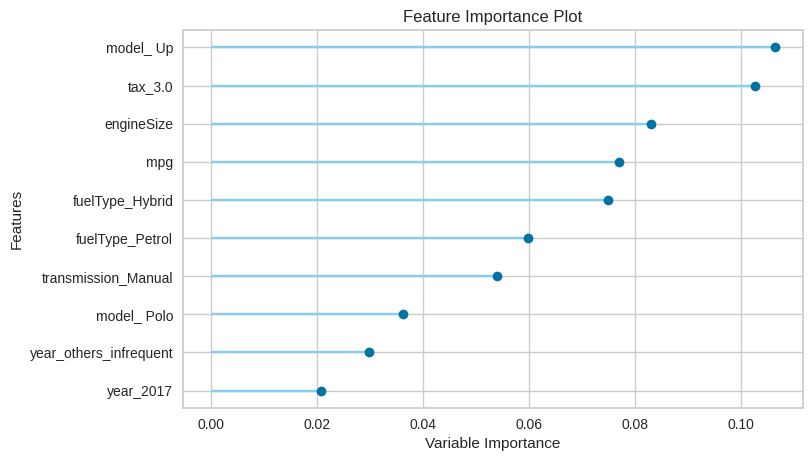

In [55]:
plot_model(estimator=model, plot='feature')

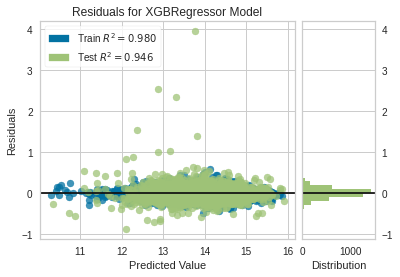

In [63]:
# 0.977-0.912, 0.978-0.902
plot_model(estimator=model) # lo2, keep outlier, keep low variance

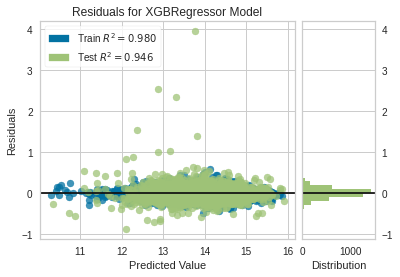

In [56]:
# 0.977-0.912, 0.978-0.902
plot_model(estimator=model)

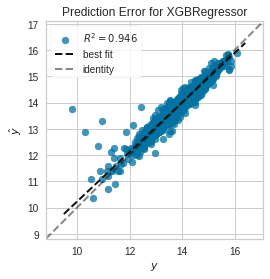

In [57]:
# 0.912, 0.902
plot_model(estimator=model, plot='error')

### 5.5 - Validation Prediction

In [ ]:
pred = predict_model(estimator=model, data=df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1055.3320,2166044.1517,1471.7487,0.9668,0.0899,0.0649


### 5.6 - Final Model

In [104]:
final_model = finalize_model(model)
save_model(model=final_model, model_name='models/xgb_regression_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['model',
                                                             'transmission',
                                                             'fuelType',
                                                             'year'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['mileage', 'mpg',
                                                           'engineSize'],
                                       target='price', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill...
                                                  learning_rate=None,
                                                  max_bin=None,
